A partir del analisis de partidos de padel, teniendo en cuenta a los equipos (no a los jugadores individuales), se realizará un modelo de machine learning supervisado con el objetivo de predecir cuál pareja gana el set (variable dependiente) a partir de las variables independientes (puntos por game, remates, errores no forzados, etc). También, se evaluará cuáles variables independientes aumentan la precision del modelo y cuales se podrian descartar

In [1]:
import numpy as np
from scipy import stats
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_excel("_ml1_eqxset.xlsx")

In [3]:
#quitar outlier de sd en bruselas 3er set
df.drop(49, axis=0, inplace=True)

#cambiar index
df.set_index('nombre',inplace=True)

In [9]:
#todas las columnas
all_cols = ['nf', 'w', 'sm', 'ns', 'csm', 'fondo', 'm3', 'm5',
       'm7', 'pto_tot', 'tot_snf', 'ed','games jug', "set"]

#columnas para ML
res_col = ["nf", "pto_tot", "tot_snf", "games jug"]

Del dataframe nos quedamos con los sets en donde no hubo tiebreak, en el cual hay un ganador y un perdedor. El tiebreak tiene reglas diferentes a la de los otros sets, por lo que lo consideramos empate.

In [10]:
#df con set ganados
df_gano = df[df["gano_set"]=="g"]

#del set ganado, nos quedamos con las columnas para el ML
df_gano = df_gano[res_col]

#normalizamos todas las columnas para obtener valores en un game
df_ganoxgame = round(df_gano.div(df_gano["games jug"], axis=0),3)

#agregamos columna con el resultado g (ganó)
df_ganoxgame["result"] ="g"

df_ganoxgame.head()

,nf,pto_tot,tot_snf,games jug,result
nombre,,,,,
Tap-Coe,0.200,2.900,1.900,1.0,g
Tap-Coe,0.556,3.444,2.222,1.0,g
Tap-Coe,0.600,3.200,1.800,1.0,g
Momo-Sanyo,0.900,2.800,1.900,1.0,g
Tap-Coe,0.900,2.800,1.900,1.0,g


In [11]:
#df con set perdidos
df_perdio = df[df["gano_set"]=="p"]

#del set perdio, nos quedamos con las columnas para el ML
df_perdio = df_perdio[res_col]

#normalizamos todas las columnas para obtener valores en un game
df_perdioxgame = round(df_perdio.div(df_perdio["games jug"], axis=0),3)

#agregamos columna con el resultado p (perdió)
df_perdioxgame["result"] ="p"

df_perdioxgame.head()

,nf,pto_tot,tot_snf,games jug,result
nombre,,,,,
Gal-Leb,1.000,2.000,1.800,1.0,p
Tello-Ruiz,1.222,1.889,1.333,1.0,p
Tello-Ruiz,1.400,2.400,1.800,1.0,p
Paquito-Chingotto,0.900,3.200,2.300,1.0,p
Stupa-Di,0.900,3.200,2.300,1.0,p


Concatenamos los dataframes de los sets perdidos y ganados, y transformamos el ganar en 1, y el perder en 0

In [12]:
#unimos dataframes
all = pd.concat([df_ganoxgame, df_perdioxgame])

#borramos la columna con los games jugados porque no tienen utilidad
all.drop("games jug", axis=1, inplace=True)

#transformamos la variable de categorica a numerica. g es 1, p es 0
all["result"] = np.where(all["result"] == "g",1,0)
all.head()

,nf,pto_tot,tot_snf,result
nombre,,,,
Tap-Coe,0.200,2.900,1.900,1
Tap-Coe,0.556,3.444,2.222,1
Tap-Coe,0.600,3.200,1.800,1
Momo-Sanyo,0.900,2.800,1.900,1
Tap-Coe,0.900,2.800,1.900,1


se crea la funcion entrenar y se entrena con el 80%

In [13]:
def entrenar(df_):
    xx = df_[df_.columns[:-1]].values
    yy = df_[df_.columns[-1]].values
    
    return xx, yy
xx, yy = entrenar(all)

x_train, x_test, y_train, y_test = train_test_split(xx,yy, test_size=0.2, random_state=45, stratify=yy)


se crea la funcion vecinos para evaluar cantidad de k optima

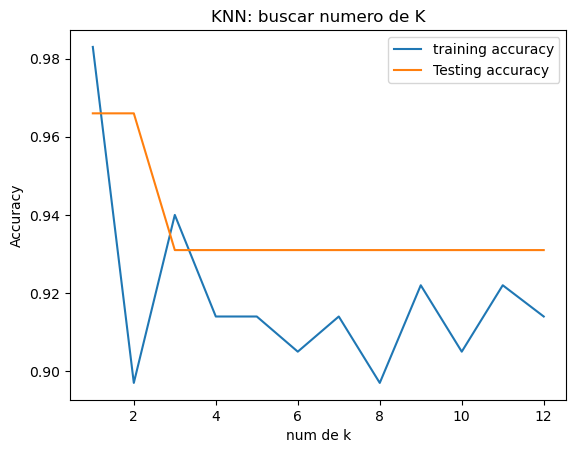

In [14]:
def vecinos():
    neighbors = np.arange(1,13)
    train_accuracies = {}
    test_accuracies = {}
    for neighbor in neighbors:
        model = KNeighborsClassifier(n_neighbors=neighbor)
        model.fit(x_train, y_train)
    
        #computar precision
        train_accuracies[neighbor] = round(model.score(x_train, y_train),3)
        test_accuracies[neighbor] = round(model.score(x_test, y_test),3)
    #print(test_accuracies)
    #print(neighbor,"\n", train_accuracies, "\n", test_accuracies)
    plt.title("KNN: buscar numero de K")
    plt.plot(neighbors, train_accuracies.values(),label= "training accuracy")
    plt.plot(neighbors, test_accuracies.values(), label = "Testing accuracy")
    plt.legend()
    plt.xlabel("num de k")
    plt.ylabel("Accuracy")
    plt.show()
vecinos()

3 es el k con la acurracy mas alta, por lo que se usará k=3 en el modelo de KNeighborsClassifier

In [15]:
num_k = 3


#elegir modelo
knn = KNeighborsClassifier(n_neighbors=num_k)
lg = LogisticRegression()
svm_model = SVC() #support vector machine
nb = GaussianNB() #naibes


mejor_modelo = None
mejor_puntaje = 0
dicc_prec = {}
list_model = {"knn":knn, "lg":lg, "svm":svm_model, "nb":nb}

for key, modelo in list_model.items():
    modelo.fit(x_train, y_train)
    y_pred = modelo.predict(x_test)

    #obtenemos el puntaje
    puntaje = modelo.score(x_test, y_test)
    dicc_prec[key] = puntaje
    
    if puntaje > mejor_puntaje:
        mejor_puntaje = puntaje
        mejor_modelo = modelo
        
#tenemos el mejor modelo es la variable, mejor_modelo, asi que ahora se entrena
mejor_modelo.fit(x_train, y_train)
y_predict = mejor_modelo.predict(x_test)


In [16]:
print("El modelo con el mayor puntaje es:", mejor_modelo, round(mejor_puntaje,2))

El modelo con el mayor puntaje es: SVC() 0.97


In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       0.94      1.00      0.97        15

    accuracy                           0.97        29
   macro avg       0.97      0.96      0.97        29
weighted avg       0.97      0.97      0.97        29



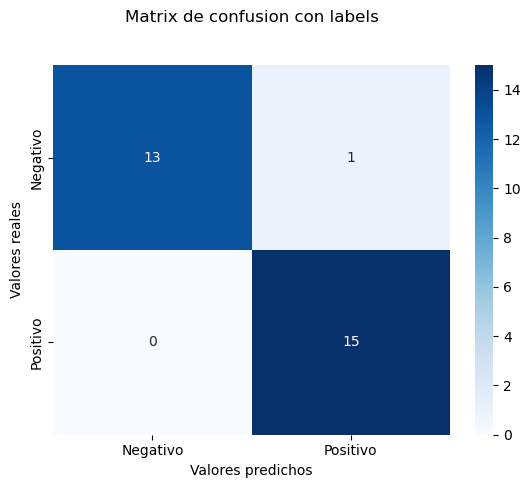

In [18]:
cf_matrix = confusion_matrix(y_test,y_predict)
ax = sns.heatmap(cf_matrix, annot=True, cmap="Blues")
ax.set_title("Matrix de confusion con labels\n\n")
ax.set_xlabel("Valores predichos")
ax.set_ylabel("Valores reales")
#ticket labels en orden alfabetico
ax.xaxis.set_ticklabels(["Negativo", "Positivo"])
ax.yaxis.set_ticklabels(["Negativo", "Positivo"])
plt.show()

el modelo tenia 97% de precision, por lo que se observa que solo en una observacion hubo un falso positivo, habian perdido pero lo predijo como que habian ganado el set.